# Fully Visible Sigmoid Belief Networks with MNIST (or Fashion MNIST)

* This code is available to tensorflow version 2.0
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) and [`tf.losses`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses)

## 1. Import modules

In [2]:
import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 2. Setting hyperparameters

In [18]:
# Training Flags (hyperparameter configuration)
model_name = 'fvsbn'
train_dir = os.path.join('train', model_name, 'exp1')
dataset_name = 'mnist'
assert dataset_name in ['mnist', 'fashion_mnist']

max_epochs = 10
save_model_epochs = 1
print_steps = 100
save_images_epochs = 1
batch_size = 128
learning_rate = 2e-2
num_examples_to_generate = 16
MNIST_SIZE = 28

## 3. Load the MNIST dataset

In [4]:
# Load training and eval data from tf.keras
if dataset_name == 'mnist':
  (train_images, train_labels), (test_images, test_labels) = \
      tf.keras.datasets.mnist.load_data()
  p = 0.5
else:
  (train_images, train_labels), (test_images, test_labels) = \
      tf.keras.datasets.fashion_mnist.load_data()
  p = 0.3

train_images = train_images.reshape(-1, MNIST_SIZE * MNIST_SIZE).astype('float32')
train_images = train_images / 255.

# Binarization
train_images[train_images >= p] = 1.
train_images[train_images < p] = 0.

11501568/11490434 [==============================] - 0s 0us/step


label = 5


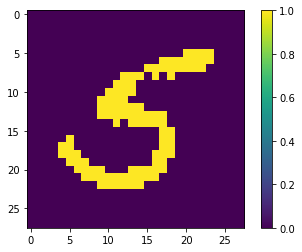

In [5]:
index = 219
print("label = {}".format(train_labels[index]))

plt.imshow(train_images[index].reshape([MNIST_SIZE, MNIST_SIZE]))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

## 4. Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [6]:
#tf.random.set_seed(219)

# for train
N = len(train_images)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
print(train_dataset)

<BatchDataset shapes: (128, 784), types: tf.float32>


## 5. Create the generator and discriminator models

In [7]:
def log_pmf(sample, probability):
  epsilon = 1e-10
  return sample * tf.math.log(probability + epsilon) + (1.-sample) * tf.math.log(1.-probability + epsilon)

In [8]:
class FullyVisibleSigmoidBeliefNetwork(tf.keras.Model):
  def __init__(self):
    """Initiailize learnable parameters.
    
    Values:
      self.models (list): list of 783 dense layers
      self.init_pixel_logit (float32 0-rank Tensor): unnormalized probability that first pixel value will be 1
    """
    super(FullyVisibleSigmoidBeliefNetwork, self).__init__()
    self.models = []
    self.init_pixel_logit = tf.Variable(0.0)
    for i in range(1, MNIST_SIZE**2):
      self.models.append(layers.Dense(units=1, activation='sigmoid'))

  def call(self, inputs):
    """Build a log likelihood function.
    
    Args:
      inputs (float32 2-rank Tensor): MNIST data in one batch
      
    Returns:
      logpx (float32 2-rank Tensor): log likelihood of corresponding batch data
    """
    probability = tf.nn.sigmoid(self.init_pixel_logit)
    logpx = log_pmf(inputs[:, 0:1], probability)
    for i in range(1, MNIST_SIZE**2):
      probability = self.models[i-1](inputs[:, 0:i])
      logpx += log_pmf(inputs[:, i:i+1], probability)
      
    return logpx
  
  def sampling(self, num_samples):
    """Sample images
    
    Args:
      num_samples (int): number of sample images
      
    Returns:
      samples (float32 2-rank Tensor): sampling images
    """
    init_pixel_probability = tf.nn.sigmoid(self.init_pixel_logit)
    samples = tf.Variable(initial_value=tf.zeros([num_samples, MNIST_SIZE**2], dtype=tf.int32))
    samples[:, 0:1].assign(tf.transpose(
                              tf.random.categorical(tf.math.log([[1. - init_pixel_probability, init_pixel_probability]]),
                                                    num_samples=num_samples, dtype=tf.int32)))
    
    for i in range(1, MNIST_SIZE**2):
      probability_ith_pixel = self.models[i-1](tf.cast(samples[:, 0:i], dtype=tf.float32)).numpy() # actually i+1 th pixel
      samples[:, i:i+1].assign(tf.random.categorical(tf.math.log(tf.concat((1. - probability_ith_pixel,
                                                                            probability_ith_pixel), axis=1)),
                                                     num_samples=1, dtype=tf.int32))
    return samples

In [9]:
fvsbn = FullyVisibleSigmoidBeliefNetwork()

## 6. Define the loss functions and the optimizer

* Actually we use the log likelihood function as loss function

### Define optimizer

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

## 7. Training

### Define training one step function

In [11]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  with tf.GradientTape() as tape:
    log_likelihood = fvsbn(images)
    loss = -tf.reduce_mean(log_likelihood) # expected negative_log_likelihood
      
  gradients = tape.gradient(loss, fvsbn.variables)
  optimizer.apply_gradients(zip(gradients, fvsbn.trainable_variables))
  
  return loss

### Train full steps

Epochs: 1.07 global_step: 500 loss: 85.2 (313.31 examples/sec; 0.409 sec/batch)


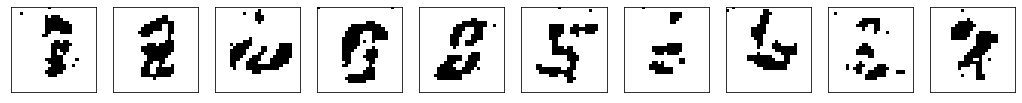

KeyboardInterrupt: ignored

In [19]:
print('Start Training.')
num_batches_per_epoch = int(N / batch_size)
global_step = tf.Variable(0, trainable=False)

for epoch in range(max_epochs):
  
  for step, images in enumerate(train_dataset):
    start_time = time.time()
    
    loss = train_step(images)
    global_step.assign_add(1)

    if global_step.numpy() % print_steps == 0:
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      display.clear_output(wait=True)
      print("Epochs: {:.2f} global_step: {} loss: {:.3g} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), loss.numpy(), examples_per_sec, duration))
      sample_images = fvsbn.sampling(num_examples_to_generate)
      sample_images = tf.reshape(sample_images, (-1, 28, 28))

      plt.figure(figsize=[18, 3])
      for i in range(10):
          plt.subplot(1, 10, i+1)
          plt.imshow(sample_images[i], cmap='Greys')
          plt.xticks([])
          plt.yticks([])
      plt.show()
    
print('Training Done.')